<a href="https://colab.research.google.com/github/Syk-yr/actor_critic/blob/main/DDPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  # DDPG
  # 目标网络:
    # actor_t 输入为actor网络输出的a与环境交互后的下一个状态s'
    # critic_t 输入是actor_t产生的a,及下一个状态s',输出是下一状态的Q(s',a')的q_t值
    # critic_t gamma * q_t  + r_s = y值
  # 实现网络: 
    # actor: 输入是buffer中的数据的state,输出是动作a
    # critic:输入是buffer中的数据的state和action,输出是s状态的实际的q值
  # 损失
    # 就是一个buffer中(y-q)的均方值
    

In [28]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [29]:
problem = "Pendulum-v0"
env = gym.make(problem)

num_states = env.observation_space.shape[0]
print("Size of state space -> {}".format(num_states))
print(env.observation_space)
num_actions = env.action_space.shape[0]
print("size of action space -> {}".format(num_actions))
print(env.action_space)

Size of state space -> 3
Box(-8.0, 8.0, (3,), float32)
size of action space -> 1
Box(-2.0, 2.0, (1,), float32)


In [30]:
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max value of action ->{}".format(upper_bound))
print("Min value of action -> {}".format(lower_bound))


Max value of action ->2.0
Min value of action -> -2.0


采样噪声

To implement better exploration by the Actor network, we use noisy perturbations, specifically an Ornstein-Uhlenbeck process for generating noise, as described in the paper. It samples noise from a correlated normal distribution.

In [31]:
class OUActionNoise:
  def __init__(self,mean,std_deviation, theta=0.15,dt=1e-2,x_initial=None):
    self.theta = theta
    self.mean =  mean
    self.std_deviation = std_deviation
    self.dt = dt
    self.x_initial = x_initial
    self.reset()

  def __call__(self):
    #  Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
    x = self.x_prev 
    x += (self.theta*(self.mean-self.x_prev)*self.dt)
    x += (self.std_deviation*np.sqrt(self.dt)*np.random.normal(size=self.mean.shape))
    self.prev = x
    return x

  def reset(self):
    if self.x_initial is not None:
      self.x_prev = self.x_initial
    else:
      self.x_prev = np.zeros_like(self.mean)

The Buffer class implements Experience Replay.

Critic loss - Mean Squared Error of y - Q(s, a) where y is the expected return as seen by the Target network, and Q(s, a) is action value predicted by the Critic network. y is a moving target that the critic model tries to achieve; we make this target stable by updating the Target model slowly.

Actor loss - This is computed using the mean of the value given by the Critic network for the actions taken by the Actor network. We seek to maximize this quantity.

Hence we update the Actor network so that it produces actions that get the maximum predicted value as seen by the Critic, for a given state.


In [42]:
class Buffer:
  def __init__(self,buffer_capacity=100000, batch_size = 64):
    self.buffer_capacity = buffer_capacity
    self.batch_size = batch_size

    # Its tells us num of times record() was called.
    self.buffer_counter = 0

    # Instead of list of tuples as the exp.replay concept go
    # We use different np.arrays for each tuple element
    self.state_buffer = np.zeros((self.buffer_capacity,num_states))#100000 * 3
    self.action_buffer = np.zeros((self.buffer_capacity,num_actions))#100000 * 1
    self.reward_buffer = np.zeros((self.buffer_capacity,1))
    self.next_state_buffer = np.zeros((self.buffer_capacity,num_states))

  # Takes (s,a,r,s') obervation tuple as input
  def record(self,obs_tuple):
    # Set index to zero if buffer_capacity is exceeded,
    # replacing old records
    index = self.buffer_counter % self.buffer_capacity

    self.state_buffer[index] = obs_tuple[0]
    self.action_buffer[index] = obs_tuple[1]
    self.reward_buffer[index] = obs_tuple[2]
    self.next_state_buffer[index] = obs_tuple[3]

    self.buffer_counter += 1

  # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
  # TensorFlow to build a static graph out of the logic and computations in our function.
  # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
  # DDPG
  # 目标网络:
    # actor_t 输入为actor网络输出的a与环境交互后的下一个状态s'
    # critic_t 输入是actor_t产生的a,及下一个状态s',输出是下一状态的Q(s',a')的q_t值
    # critic_t gamma * q_t  + r_s = y值
  # 实现网络: 
    # actor: 输入是buffer中的数据的state,输出是动作a
    # critic:输入是buffer中的数据的state和action,输出是s状态的实际的q值
  # 损失
    # critic_loss 一个buffer中(y-q)的均方值 
    # actor_loss q的均值的负数

  # @tf.function
  def update(self, state_batch, action_batch, reward_batch, next_state_batch):
    # Training and updating Actor & Critic networks.
    # See Pseudo Code.
    with tf.GradientTape() as tape:
      target_actions = target_actor(next_state_batch, training=True)
      y = reward_batch + gamma*target_critic([next_state_batch,target_actions],training=True)

      critic_value = critic_model([state_batch,action_batch],training=True)
      critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

    critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
    critic_optimizer.apply_gradients(zip(critic_grad, critic_model.trainable_variables))

    with tf.GradientTape() as tape:
      actions = actor_model(state_batch, training =True)
      critic_value = critic_model([state_batch,actions],training=True)

      actor_loss = -tf.math.reduce_mean(critic_value)
    
    actor_grad = tape.gradient(actor_loss,actor_model.trainable_variables)
    actor_optimizer.apply_gradients(zip(actor_grad,actor_model.trainable_variables))

  
  # we compute the loss and update parameters
  def learn(self):
    # get sampling range
    record_range = min(self.buffer_counter,self.buffer_capacity)
    # randomlu sample indices
    batch_indices = np.random.choice(record_range,self.batch_size)

    # convert to tensors
    state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
    action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
    reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
    reward_batch = tf.cast(reward_batch,dtype=tf.float32)
    next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

    self.update(state_batch,action_batch,reward_batch,next_state_batch)

# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
# weights表示实现网络的参数,target_weight表示目标网络的参数,通过tau*weights + (1-tau)*target_weights来更新目标网络
def update_target(target_weights,weights,tau):
  for (a,b) in zip(target_weights,weights):
    a.assign(b*tau + a*(1-tau))


Here we define the Actor and Critic networks. These are basic Dense models with ReLU activation.

Note: We need the initialization for last layer of the Actor to be between -0.003 and 0.003 as this prevents us from getting 1 or -1 output values in the initial stages, which would squash our gradients to zero, as we use the **tanh **activation.

In [43]:
def get_actor():
  # initialize weights between -3e-3 and 3e-3
  last_init = tf.random_uniform_initializer(minval=-0.003,maxval=0.003)

  inputs = layers.Input(shape=(num_states,))
  out=layers.Dense(256,activation='relu')(inputs)
  out = layers.Dense(256,activation='relu')(out)
  outputs = layers.Dense(1,activation='tanh',kernel_initializer=last_init)(out)

  # our upper bound is 2.0 Pendulum
  outputs = outputs * upper_bound
  model = tf.keras.Model(inputs,outputs)#
  return model

def get_critic():
  # state as input
  state_input = layers.Input(shape=(num_states))
  state_out = layers.Dense(16,activation='relu')(state_input)
  state_out = layers.Dense(32,activation='relu')(state_out)

  # action as input
  action_input = layers.Input(shape=(num_actions))
  action_out = layers.Dense(32,activation='relu')(action_input)

  # both are passed through seperate layer before concatenating
  concat = layers.Concatenate()([state_out,action_out])

  out = layers.Dense(256,activation='relu')(concat)
  out = layers.Dense(256,activation='relu')(out)
  outputs = layers.Dense(1)(out)

  # outputs single value for give state-action
  model = tf.keras.Model([state_input,action_input],outputs)

  return model

policy() returns an action sampled from our actor network plus some noise for exploration

In [44]:
def policy(state,noise_object):
  sampled_actions = tf.squeeze(actor_model(state))
  noise = noise_object()
  # add noise to action
  sampled_actions = sampled_actions.numpy() + noise

  # we make sure action is within bounds
  legal_action = np.clip(sampled_actions,lower_bound,upper_bound)
  # print(legal_action)
  # print(np.squeeze(legal_action))
  return [np.squeeze(legal_action)]

# Training hyperparameters

In [45]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1),std_deviation=float(std_dev)*np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# learning rate for actor-critic models
actor_lr = 0.001
critic_lr = 0.002

actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)

total_episode = 100

# discount factor for future rewards
gamma = 0.99

# used to update target networks

tau = 0.005

buffer = Buffer(50000,64)

Now we implement our main training loop, and iterate over episodes. We sample actions using policy() and train with learn() at each time step, along with updating the Target networks at a rate tau.

Episode * 0 * Avg Reward is ==> -1417.105477093242
Episode * 10 * Avg Reward is ==> -666.248679498691
Episode * 20 * Avg Reward is ==> -424.0046710640386
Episode * 30 * Avg Reward is ==> -333.48116318686726
Episode * 40 * Avg Reward is ==> -255.16063395304582
Episode * 50 * Avg Reward is ==> -145.54671607761466
Episode * 60 * Avg Reward is ==> -147.39695077529615
Episode * 70 * Avg Reward is ==> -161.0831514755999
Episode * 80 * Avg Reward is ==> -185.0682709849495
Episode * 90 * Avg Reward is ==> -188.97819268127245


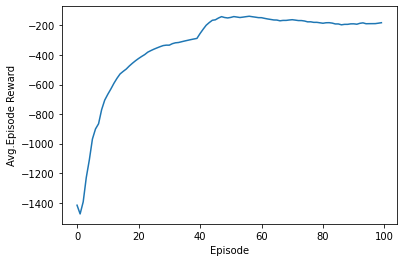

In [48]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episode
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episode):
  prev_state = env.reset()
  episodic_reward = 0

  while True:
    # uncomment this to see the actor in action
    # but not in a python notebook
    # env.render()

    tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state),0)
    action = policy(tf_prev_state,ou_noise)
    # recieve state and rewards from environment
    state, reward,done,info = env.step(action)

    buffer.record((prev_state,action,reward,state))
    episodic_reward += reward

    buffer.learn()

    update_target(target_actor.variables,actor_model.variables,tau)
    update_target(target_critic.variables,critic_model.variables,tau)

    # end this episode when done is true
    if done:
      break
    
    prev_state = state

  ep_reward_list.append(episodic_reward)

  # mean of last 40 episodes
  avg_reward = np.mean(ep_reward_list[-40:])
  if ep%10 == 0:
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
  avg_reward_list.append(avg_reward)

# plotting graph
# episode verus avg.reward
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg.Episode Reward")
plt.show()


If training proceeds correctly, the average episodic reward will increase with time.

Feel free to try different learning rates, tau values, and architectures for the Actor and Critic networks.

The Inverted Pendulum problem has low complexity, but DDPG work great on many other problems.

Another great environment to try this on is LunarLandingContinuous-v2, but it will take more episodes to obtain good results.

In [49]:
# save the weight
actor_model.save_weights("pendulum_actor.h5")
critic_model.save_weights("pendulun_critic.h5")

target_actor.save_weights("pendulum_target_actor.h5")
target_critic.save_weights("pendulum_target_critic.h5")